# $MAPF_R$ environment

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np

In [34]:
node_locs = np.array([[1,1],
                      [0,2],
                      [1,3],
                      [3,3],
                      [4,2],
                      [3,1]])
N = len(node_locs)

G = nx.Graph()
G.add_nodes_from(range(N))
G.add_edges_from([(0,1),
                  (1,2),
                  (2,3),
                  (3,4),
                  (4,5),
                  (5,0),
                  (0,3)])
G = nx.to_directed(G)

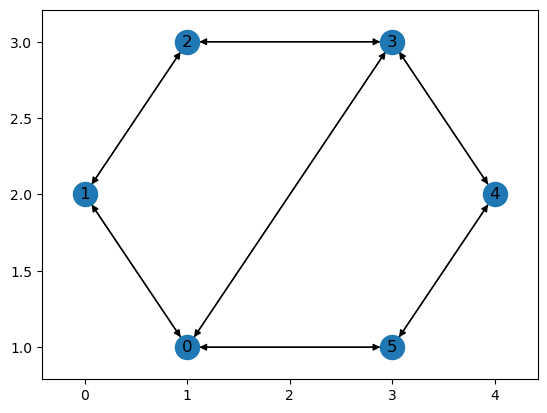

In [36]:
ax = plt.gca()
nx.draw_networkx(G, {n:node_locs[n] for n in G},ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [ ]:
start_node = 0
goal_node = 4

agent_loc = node_locs[start_node]
bloating_radius = 1.0

from matplotlib.patches import Circle
disc = Circle()